In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

C:\Users\jiahaozhang\AppData\Local\Temp\ipykernel_53324\1226147920.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


# Stimulus-driven predictive model of brain activity: ROI-wise.

In [2]:
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict, zip_dict
from src.config import *

%matplotlib inline

In [3]:
import torch
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 1
device#: 0
device name: NVIDIA GeForce RTX 2080

torch: 2.6.0+cu126
cuda:  12.6
cudnn: 90501
dtype: torch.float32


In [4]:
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime()) # 'Aug-10-2020_1638' #

model_name = 'gnet8r_mpf_evc'
model_dir = '%s_%s' % (model_name, timestamp)

output_dir = root_dir+"output/multisubject/%s_%s/" % (model_name,timestamp) 

trn_subjects = [1]
for k,s in enumerate(trn_subjects): 
    subject_dir = output_dir + 'S%02d/'%s
    if not os.path.exists(subject_dir):
        os.makedirs(subject_dir)   
print ("Time Stamp: %s" % timestamp)

Time Stamp: May-03-2025_1605


# Load the stimuli images
From the subjectwise image preparation

In [5]:
exp_design = loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)

image_data = {}
for s in trn_subjects: 
    image_data_set = h5py.File(stim_dir + "S%d_stimuli_227.h5py"%s, 'r')
    image_data[s] = np.copy(image_data_set['stimuli'])
    image_data_set.close()
    print ('--------  subject %d  -------' % s)
    print ('block size:', image_data[s].shape, ', dtype:', image_data[s].dtype, ', value range:',\
           np.min(image_data[s][0]), np.max(image_data[s][0]))

--------  subject 1  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255


## Examples

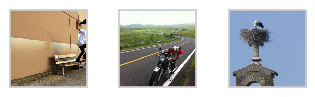

In [6]:
n = 1003
plt.figure(figsize=(4,1*len(trn_subjects)))
for k,s in enumerate(trn_subjects): 
    for i in range(3):
        plt.subplot(len(trn_subjects), 3, 3*k+i+1)
        plt.imshow(image_data[s][n+i].transpose((1,2,0)), cmap='gray', interpolation='None')
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)

# Load the voxel data
- We load a subset (a range of voxels) of all voxel for the sake of the example.

In [7]:
from src.file_utility import load_mask_from_nii, view_data
from src.roi import roi_map, iterate_roi

In [8]:
beta_dir = 'C:/Data/nsd/nsddata_betas/ppdata/'

In [9]:
group_names = ['V1', 'V2', 'V3', 'hV4', 'V3ab', 'LO', 'IPS', 'VO', 'PHC', 'MT', 'MST', 'other']
group = [[1,2],[3,4],[5,6], [7], [16, 17], [14, 15], [18,19,20,21,22,23], [8, 9], [10,11], [13], [12], [24,25,0]]

brain_nii_shape, voxel_mask, voxel_idx, voxel_roi, voxel_ncsnr = {}, {}, {}, {}, {}

for k,s in enumerate(trn_subjects):
    print ('--------  subject %d  -------' % s)
    voxel_mask_full = load_mask_from_nii(mask_dir + "subj%02d/func1pt8mm/brainmask_vcventral_1.0.nii"%s)
    #voxel_mask_full = load_mask_from_nii(mask_dir + "subj%02d/func1pt8mm/brainmask_nsdgeneral_1.0.nii"%s)
    voxel_roi_full  = load_mask_from_nii(mask_dir0 + "subj%02d/func1pt8mm/roi/prf-visualrois.nii.gz"%s)
    voxel_kast_full = load_mask_from_nii(mask_dir0 + "subj%02d/func1pt8mm/roi/Kastner2015.nii.gz"%(s))
    general_mask_full  = load_mask_from_nii(mask_dir0 + "subj%02d/func1pt8mm/roi/nsdgeneral.nii.gz"%(s))
    ncsnr_full = load_mask_from_nii(beta_dir + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/ncsnr.nii.gz"%s)
    ###
    brain_nii_shape[s] = voxel_roi_full.shape
    print (brain_nii_shape[s])
    ###
    voxel_roi_mask_full = (voxel_roi_full>0).flatten().astype(bool)
    voxel_joined_roi_full = np.copy(voxel_kast_full.flatten())  # load kastner rois
    voxel_joined_roi_full[voxel_roi_mask_full] = voxel_roi_full.flatten()[voxel_roi_mask_full] # overwrite with prf rois
    ###
    voxel_mask[s]  = np.nan_to_num(voxel_mask_full).flatten().astype(bool)
    voxel_idx[s]   = np.arange(len(voxel_mask[s]))[voxel_mask[s]]
    voxel_roi[s]   = voxel_joined_roi_full[voxel_mask[s]]
    voxel_ncsnr[s] = ncsnr_full.flatten()[voxel_mask[s]]
        
    print ('full mask length = %d'%len(voxel_mask[s]))
    print ('selection length = %d'%np.sum(voxel_mask[s]))
    
    for roi_mask, roi_name in iterate_roi(group, voxel_roi[s], roi_map, group_name=group_names):
        print ("%d \t: %s" % (np.sum(roi_mask), roi_name))

--------  subject 1  -------
(81, 104, 83)
full mask length = 699192
selection length = 4657
1350 	: V1
1433 	: V2
1187 	: V3
687 	: hV4
0 	: V3ab
0 	: LO
0 	: IPS
0 	: VO
0 	: PHC
0 	: MT
0 	: MST
0 	: other


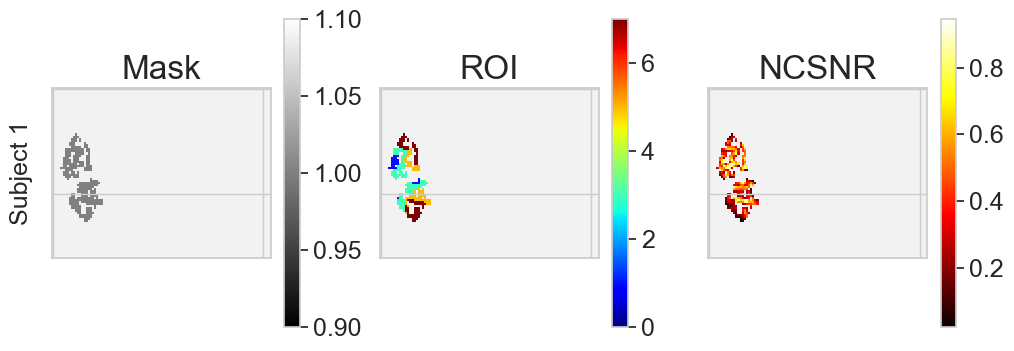

In [10]:
slice_idx = 35
plt.figure(figsize=(12, 4*len(trn_subjects)))
for k,s in enumerate(trn_subjects): 
    subject_dir = output_dir + 'S%02d/'%s
    if not os.path.exists(subject_dir):
        os.makedirs(subject_dir)
    
    volume_brain_mask = view_data(brain_nii_shape[s], voxel_idx[s], np.ones_like(voxel_idx[s]), save_to=subject_dir+"subj%02d_mask"%s)
    volume_brain_roi  = view_data(brain_nii_shape[s], voxel_idx[s], voxel_roi[s], save_to=subject_dir+"subj%02d_roi"%s)
    volume_ncsnr      = view_data(brain_nii_shape[s], voxel_idx[s], voxel_ncsnr[s], save_to=subject_dir+"subj%02d_ncsnr"%s) 
    ##
    plt.subplot(len(trn_subjects),3,3*k+1)
    plt.imshow(volume_brain_mask[:,:,slice_idx], cmap='gray', interpolation='None')
    plt.title('Mask')
    plt.colorbar()
    _=plt.ylabel('Subject %d'%s)
    _=plt.gca().set_xticklabels([])
    _=plt.gca().set_yticklabels([])
    plt.subplot(len(trn_subjects),3,3*k+2)
    plt.imshow(volume_brain_roi[:,:,slice_idx], cmap='jet', interpolation='None')
    plt.clim([0,7])
    plt.title('ROI')
    plt.colorbar()
    _=plt.gca().set_xticklabels([])
    _=plt.gca().set_yticklabels([])
    plt.subplot(len(trn_subjects),3,3*k+3)
    plt.imshow(volume_ncsnr[:,:,slice_idx], cmap='hot', interpolation='None')
    plt.title('NCSNR')
    plt.colorbar()
    _=plt.gca().set_xticklabels([])
    _=plt.gca().set_yticklabels([])

# Create the batched voxel masks 

In [11]:
block_group_names = ['V1', 'V2', 'V3', 'hV4'] #['V1', 'V2', 'V3', 'hV4-LO', 'IPS', 'other']
block_group = [[1,2], [3,4], [5,6], [7]] # [[1,2], [3,4], [5,6], [7,14,15], [18,19,20,21,22,23], [8,9,10,11,12,13,16,17,24,25,0]]

In [35]:
block_voxel_masks = {}
for roi_name in block_group_names:
    block_voxel_masks[roi_name] = {}

for s in trn_subjects:
    for roi_mask, roi_name in iterate_roi(block_group, voxel_roi[s], roi_map, group_name=block_group_names):    
        block_voxel_masks[roi_name][s] = roi_mask

print (['%s: %d'%(s,np.sum(v)) for s,v in flatten_dict(block_voxel_masks).items()])

['V1.1: 1350', 'V2.1: 1433', 'V3.1: 1187', 'hV4.1: 687']


# Load voxels
Only run one of these cells
## Quick load (Load the voxel data block for these voxels only)

In [13]:
voxel_data_set = h5py.File(voxel_dir+'voxel_data_general_part1_gnet8j.h5py', 'r')
voxel_data_dict = embed_dict({k: np.copy(d) for k,d in voxel_data_set.items()})
voxel_data_set.close()
voxel_data = {int(k): v for k, v in voxel_data_dict['voxel_data'].items()}

# Dataset split and unpacking or averaging
## Reduce the stimulus set to those of which we have responses so far.
- It just so happens that images with index less than 1000 are shared among subjects and are garanteed not to be shown in the remainder. We therefore chose to reparate our training and validation set along these lines.

In [14]:
from src.load_nsd import image_feature_fn, ordering_split
trn_stim_ordering, trn_voxel_data, val_stim_ordering, val_voxel_data = {},{},{},{}

stim_data = {}
data_size, nnv = {}, {}
for k,s in enumerate(trn_subjects):
    print ('--------  subject %d  -------' % s)
    data_size[s], nnv[s] = voxel_data[s].shape      
    stim_data[s] = image_feature_fn(image_data[s])
    
    trn_stim_ordering[s], trn_voxel_data[s], \
    val_stim_ordering[s], val_voxel_data[s] = \
        ordering_split(voxel_data[s], ordering, combine_trial=False)
    
del image_data
del voxel_data

--------  subject 1  -------
Total number of voxels = 4657


In [15]:
trn_stim_mean = sum([np.mean(stim_data[s][1000:], axis=(0,2,3), keepdims=True) for s in trn_subjects])/len(trn_subjects)
print (trn_stim_mean)

[[[[0.47777689]]

  [[0.45385954]]

  [[0.41320467]]]]


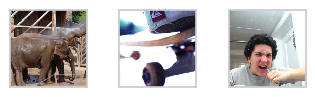

In [16]:
n = 1006
plt.figure(figsize=(4,1*len(trn_subjects)))
for k,s in enumerate(trn_subjects): 
    for i in range(3):
        plt.subplot(len(trn_subjects), 3, 3*k+i+1)
        plt.imshow(stim_data[s][n+i].transpose((1,2,0)), cmap='gray', interpolation='None')
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)

In [17]:
s=1
voxel_subset = {}
ordering_subset = {}
val_voxel_subset = {}
val_ordering_subset = {}
val_stim_subset = {}
max_samples = 1000
val_max_samples = 2000
max_voxels = 2000
val_max_voxels = 2000

num_samples = min(max_samples, trn_voxel_data[s].shape[0])
num_voxels = min(max_voxels, trn_voxel_data[s].shape[1])
val_num_samples = min(val_max_samples, val_voxel_data[s].shape[0])
val_num_voxels = min(val_max_voxels, val_voxel_data[s].shape[1])
subset_idx = np.arange(num_samples)
val_subset_idx = np.arange(val_num_samples)

voxel_subset[s] = trn_voxel_data[s][subset_idx, :num_voxels]
ordering_subset[s] = trn_stim_ordering[s][subset_idx]  
val_voxel_subset[s] = val_voxel_data[s][val_subset_idx, :val_num_voxels]
val_ordering_subset[s] = val_stim_ordering[s][val_subset_idx] 
val_stim_subset[s]=[]
for idx in val_ordering_subset[s]:
    val_stim_subset[s].append(stim_data[s][idx])
val_stim_subset[s]=np.array(stim_data[s])

In [18]:
print(stim_data[1].shape)

print('train subset')
print(trn_voxel_data[1].shape)
print(voxel_subset[1].shape)
print(trn_stim_ordering[1].shape)
print(ordering_subset[1].shape)

print('val subset')
print(val_voxel_data[1].shape)
print(val_voxel_subset[1].shape)
print(val_stim_ordering[1].shape)
print(val_ordering_subset[1].shape)
print(val_stim_subset[1].shape)
print(stim_data[1].shape)

(10000, 3, 227, 227)
train subset
(27000, 4657)
(1000, 2000)
(27000,)
(1000,)
val subset
(3000, 4657)
(2000, 2000)
(3000,)
(2000,)
(10000, 3, 227, 227)
(10000, 3, 227, 227)


---
# Model

In [19]:
from src.torch_joint_training_unpacked_sequences import *
from src.torch_gnet import Encoder
from src.torch_mpf import Torch_LayerwiseFWRF

## Model instanciation

In [20]:
_log_act_fn = lambda _x: T.log(1 + T.abs(_x))*T.tanh(_x)

In [21]:
def _model_fn(_ext, _con, _x):
    '''model consists of an extractor (_ext) and a connection model (_con)'''
    _y, _fm, _h = _ext(_x)
    return _con(_fm)

def _smoothness_loss_fn(_rf, n):
    delta_x = T.sum(T.pow(T.abs(_rf[:, 1:]    - _rf[:, :-1]), n))
    delta_y = T.sum(T.pow(T.abs(_rf[:, :, 1:] - _rf[:, :, :-1]), n))
    return delta_x + delta_y

def vox_loss_fn(r, v, nu=0.5, delta=1.):
    #err = T.sum(huber(r, v, delta), dim=0)
    err = T.sum((r - v)**2, dim=0)
    # squared correlation coefficient with 'leak'
    cr = r - T.mean(r, dim=0, keepdim=True)
    cv = v - T.mean(v, dim=0, keepdim=True)
    wgt = T.clamp(T.pow(T.mean(cr*cv, dim=0), 2) / ((T.mean(cr**2, dim=0)) * (T.mean(cv**2, dim=0)) + 1e-6), min=nu, max=1).detach()
 
    weighted_err = wgt * err # error per voxel
    loss = T.sum(weighted_err) / T.mean(wgt)
    return err, loss
    
def _loss_fn(_ext, _con, _x, _v):
    _r = _model_fn(_ext, _con, _x)
    #_err = T.sum((_r - _v)**2, dim=0)
    #_loss = T.sum(_err)
    _err, _loss = vox_loss_fn(_r, _v, nu=0.1, delta=.5)

    _loss += fpX(1e-1) * T.sum(T.abs(_con.w))
    return _err, _loss
    
def _training_fn(_ext, _con, _opts, xb, yb):
    for _opt in _opts:
        _opt.zero_grad()
        _err, _loss = _loss_fn(_ext, _con, T.from_numpy(xb).to(device), T.from_numpy(yb).to(device))
        _loss.backward()
        _opt.step()
    return _err

def _holdout_fn(_ext, _con, xb, yb):
    # print (xb.shape, yb.shape)
    _err,_ = _loss_fn(_ext, _con, T.from_numpy(xb).to(device), T.from_numpy(yb).to(device))
    return _err

def _pred_fn(_ext, _con, xb):
    return _model_fn(_ext, _con, T.from_numpy(xb).to(device))

def print_grads(_ext, _con, _params, _opt, xb, yb):
    _opt.zero_grad()
    _err, _loss = _loss_fn(_ext, _con, T.from_numpy(xb).to(device), T.from_numpy(yb).to(device))  
    _loss.backward()   
    for p in _params:
        prg = get_value(p.grad)     
        print ("%-16s : value=%f, grad=%f" % (list(p.size()), np.mean(np.abs(get_value(p))), np.mean(np.abs(prg))))
    print ('--------------------------------------')
    sys.stdout.flush()

In [36]:
N = 64
roi_nv = {s: np.sum(roi_mask) for s, roi_mask in block_voxel_masks['V1'].items()}
    
shared_model = Encoder(trn_stim_mean, trunk_width=N).to(device)
rec, fmaps, h = shared_model(T.from_numpy(stim_data[trn_subjects[0]][:20]).to(device))

subject_fwrfs = {s: Torch_LayerwiseFWRF(fmaps, nv=roi_nv[1], pre_nl=_log_act_fn, \
                     post_nl=_log_act_fn, dtype=np.float32).to(device) for s in trn_subjects}   

In [23]:
for s,sp in subject_fwrfs.items():
    print ("--------- subject %d ----------"%s)
    for p in sp.parameters():
        print ("block size %-16s" % (list(p.size())))
        
param_count = 0
for w in shared_model.enc.parameters():
    param_count += np.prod(tuple(w.size()))
print ('')
print (param_count, "shared params")
total_nv = 0
for s,sp in subject_fwrfs.items():
    for p in sp.parameters():
        param_count += np.prod(tuple(p.size()))
    total_nv += roi_nv[s]
print (param_count // total_nv, "approx params per voxels")

--------- subject 1 ----------
block size [1350, 25, 25]  
block size [1350, 13, 13]  
block size [1350, 512]     
block size [1350]          

1034944 shared params
2073 approx params per voxels


In [47]:
import gc
T.cuda.empty_cache()
gc.collect()

6703

# Training

In [39]:
batch_size = 100
num_epochs = 20
holdout_frac = .1

for roi_name, roi_masks in block_voxel_masks.items(): 
    print(roi_name)
    roi_nv = {s: np.sum(roi_mask) for s, roi_mask in roi_masks.items()}
    
    print ('***************************************')
    print ('***        %12s       ***'%roi_name)
    print ({s: np.sum(m) for s,m in roi_masks.items()})
    print ('***************************************') 
    
    # create model
    shared_model = Encoder(trn_stim_mean, trunk_width=N).to(device)
    rec, fmaps, h = shared_model(T.from_numpy(stim_data[trn_subjects[0]][:20]).to(device))

    subject_fwrfs = {s: Torch_LayerwiseFWRF(fmaps, nv=roi_nv[s], pre_nl=_log_act_fn, \
                     post_nl=_log_act_fn, dtype=np.float32).to(device) for s in trn_subjects}    
    
    ##################################
    try:
        from torch.hub import load_state_dict_from_url
    except ImportError:
        from torch.utils.model_zoo import load_url as load_state_dict_from_url

    state_dict = load_state_dict_from_url('https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth', progress=True)
            ### Rename dictionary keys to match new breakdown
    pre_state_dict = {}
    pre_state_dict['conv1.0.weight'] = state_dict.pop('features.0.weight')
    pre_state_dict['conv1.0.bias'] = state_dict.pop('features.0.bias')
    pre_state_dict['conv2.0.weight'] = state_dict.pop('features.3.weight')
    pre_state_dict['conv2.0.bias'] = state_dict.pop('features.3.bias')

    shared_model.pre.load_state_dict(pre_state_dict)
    ###################################
    optimizer_net = optim.Adam([
            #{'params': shared_model.pre.parameters()},
            {'params': shared_model.enc.parameters()},
        ], lr=1e-3, betas=(0.9, 0.999), eps=1e-08)
    subject_optimizer = {s: optim.Adam([
            {'params': sp.parameters()}
        ], lr=1e-3, betas=(0.9, 0.999), eps=1e-08) for s,sp in subject_fwrfs.items()}
    subject_opts = {s: [optimizer_net, subject_optimizer[s]] for s in subject_optimizer.keys()}   
    ###################################
    best_params, final_params, hold_cc_hist, hold_hist, trn_hist, best_epoch, best_joint_cc_score = \
        learn_params_(_training_fn, _holdout_fn, _pred_fn, shared_model, subject_fwrfs, subject_opts, 
            stim_data, trn_voxel_data, trn_stim_ordering,
            num_epochs=num_epochs, batch_size=batch_size, holdout_frac=holdout_frac, masks=roi_masks, randomize=False)
    
    ###################################
    #val_voxel = {s: val_voxel_data[s] for s in val_voxel_data.keys()}
    shared_model.load_state_dict(best_params['enc'])
    shared_model.eval() 
    for s,sd in subject_fwrfs.items():
        sd.load_state_dict(best_params['fwrfs'][s])
        sd.eval() 

    subject_val_cc = validation_(_pred_fn, shared_model, subject_fwrfs, stim_data, val_voxel_data, val_stim_ordering, batch_size, masks=roi_masks)
    joined_val_cc = np.concatenate(list(subject_val_cc.values()), axis=0)
    
    print ('***************************************')
    print ("best joint val cc = %.3f"% np.median(joined_val_cc))
    for s,v in subject_val_cc.items():
        print ("subject %s: val cc = %.3f"%(s, np.median(v)))
 
    print ('***************************************')
    ###################################
    torch.save({
            'group_name': roi_name,
            'num_epochs': num_epochs,
            'batch_size': batch_size,
            'holdout_frac': holdout_frac,   
            'best_params': best_params, 
            'final_params': final_params,
            'trn_loss_history': trn_hist,
            'hold_loss_history': hold_hist,
            'hold_cc_history': hold_cc_hist,
            'best_epoch': best_epoch,
            'best_joint_cc_score': best_joint_cc_score,
            'val_cc': subject_val_cc,
            'input_mean': trn_stim_mean,
            'brain_nii_shape': brain_nii_shape,
            'voxel_index': voxel_idx,
            'voxel_roi': voxel_roi,
            'voxel_mask': voxel_mask,
            'group_mask': roi_masks
            }, output_dir+'model_params_%s'%roi_name)

V1
***************************************
***                  V1       ***
{1: np.int64(1350)}
***************************************
subject 1 masked 1350 of 4657
subject 1 training/holdout 24300 2700
--: 100.0 %
  Epoch 1 of 20 took       66.919s
  training loss:               6.349998
  holdout loss (batch):        5.888837
  Subject 1: median (max) validation accuracy = 0.159 (0.477)
** Saving params with joint score = 0.159 **

--: 100.0 %
  Epoch 2 of 20 took       66.171s
  training loss:               5.672639
  holdout loss (batch):        5.804219
  Subject 1: median (max) validation accuracy = 0.195 (0.582)
** Saving params with joint score = 0.195 **

--: 100.0 %
  Epoch 3 of 20 took       66.437s
  training loss:               5.584032
  holdout loss (batch):        5.670636
  Subject 1: median (max) validation accuracy = 0.230 (0.636)
** Saving params with joint score = 0.230 **

--: 100.0 %
  Epoch 4 of 20 took       66.925s
  training loss:               5.474419
  h

# Cross-ROI models

In [43]:
input_dir  = output_dir
subset_info='1_all_epoch20'
roi_files = {
    'V1': '%smodel_params_V1_%s'%(input_dir,subset_info),
    'V2': '%smodel_params_V2_%s'%(input_dir,subset_info),
    'V3': '%smodel_params_V3_%s'%(input_dir,subset_info),
    'hV4': '%smodel_params_hV4_%s'%(input_dir,subset_info)
    }

In [52]:
batch_size = 100
num_epochs = 20
holdout_frac = .1

for roi_name, roi_file in roi_files.items(): 

    # create subdir
    model_dir     = roi_file
    output_subdir = output_dir + roi_name + '/'
    print (output_subdir)
    if not os.path.exists(output_subdir):
        os.makedirs(output_subdir)

    print ('***************************************')
    print ('***        %12s       ***'%roi_name)
    print ('from ==> %s'%model_dir)
    print ('to   ==> %s'%output_subdir)
    print ('***************************************') 
    
    
    checkpoint = torch.load(model_dir,weights_only=False)
    shared_params = checkpoint['best_params']
    ###
    
    shared_model = Encoder(trn_stim_mean, trunk_width=N).to(device)
    shared_model.load_state_dict(shared_params['enc'])
    shared_model.eval()     

    rec, fmaps, h = shared_model(T.from_numpy(stim_data[list(stim_data.keys())[0]][:20]).to(device))
    
    subject_fwrfs = {s: Torch_LayerwiseFWRF(fmaps, nv=voxel_subset[s].shape[1], pre_nl=_log_act_fn, \
                     post_nl=_log_act_fn, dtype=np.float32).to(device) for s in trn_subjects}    
    
    subject_optimizer = {s: optim.Adam([
            {'params': sp.parameters()}
        ], lr=1e-3, betas=(0.9, 0.999), eps=1e-08) for s,sp in subject_fwrfs.items()}
    subject_opts = {s: [subject_optimizer[s]] for s in subject_optimizer.keys()}   
    ###################################
    

    best_params, final_params, hold_cc_hist, hold_hist, trn_hist, best_epoch, best_joint_cc_score = \
        learn_params_(_training_fn, _holdout_fn, _pred_fn, shared_model, subject_fwrfs, subject_opts, 
            stim_data, voxel_subset, ordering_subset,
            num_epochs=num_epochs, batch_size=batch_size, holdout_frac=holdout_frac, randomize=False)
    '''best_params, final_params, hold_cc_hist, hold_hist, trn_hist, best_epoch, best_joint_cc_score = \
        learn_params_(_training_fn, _holdout_fn, _pred_fn, shared_model, subject_fwrfs, subject_opts, 
            stim_data, trn_voxel_data, trn_stim_ordering,
            num_epochs=num_epochs, batch_size=batch_size, holdout_frac=holdout_frac, randomize=False)'''
    
    ###################################
    #val_voxel = {s: val_voxel_data[s] for s in val_voxel_data.keys()}
    shared_model.load_state_dict(best_params['enc'])
    shared_model.eval() 
    for s,sd in subject_fwrfs.items():
        sd.load_state_dict(best_params['fwrfs'][s])
        sd.eval() 

    subject_val_cc = validation_(_pred_fn, shared_model, subject_fwrfs, stim_data, val_voxel_subset, val_ordering_subset, batch_size)
    joined_val_cc = np.concatenate(list(subject_val_cc.values()), axis=0)
    
    print ('***************************************')
    print ("best joint val cc = %.3f"% np.median(joined_val_cc))
    for s,v in subject_val_cc.items():
        print ("subject %s: val cc = %.3f"%(s, np.median(v)))
 
    print ('***************************************')
    ###################################
    torch.save({
            'group_name': roi_name,
            'num_epochs': num_epochs,
            'batch_size': batch_size,
            'holdout_frac': holdout_frac,   
            'best_params': best_params, 
            'final_params': final_params,
            'trn_loss_history': trn_hist,
            'hold_loss_history': hold_hist,
            'hold_cc_history': hold_cc_hist,
            'best_epoch': best_epoch,
            'best_joint_cc_score': best_joint_cc_score,
            'val_cc': subject_val_cc,
            'input_mean': trn_stim_mean,
            'brain_nii_shape': brain_nii_shape,
            'voxel_index': voxel_idx,
            'voxel_roi': voxel_roi,
            'voxel_mask': voxel_mask,
            }, output_subdir+'model_params')

C:/Data/nsd_test/output/multisubject/gnet8r_mpf_evc_May-03-2025_1605/V1/
***************************************
***                  V1       ***
from ==> C:/Data/nsd_test/output/multisubject/gnet8r_mpf_evc_May-03-2025_1605/model_params_V1_1_all_epoch20
to   ==> C:/Data/nsd_test/output/multisubject/gnet8r_mpf_evc_May-03-2025_1605/V1/
***************************************
subject 1 masked 2000 of 2000
subject 1 training/holdout 900 100
| : 100.0 %
  Epoch 1 of 20 took       7.879s
  training loss:               11.192055
  holdout loss (batch):        10.523776
  Subject 1: median (max) validation accuracy = -0.080 (0.347)

| : 100.0 %
  Epoch 2 of 20 took       4.160s
  training loss:               8.480679
  holdout loss (batch):        8.430055
  Subject 1: median (max) validation accuracy = -0.047 (0.367)

| : 100.0 %
  Epoch 3 of 20 took       4.199s
  training loss:               7.087145
  holdout loss (batch):        7.223818
  Subject 1: median (max) validation accuracy = 0.